# Interpretation Notebook

In [137]:
library(Seurat)
library(dplyr)
library(Matrix)
library(ggplot2)
library(ggpubr)
library(xtable)

### Load Sepsis Results

In [138]:
res = read.csv("/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsisres.csv")

In [139]:
head(res)

,index,id,pheno,cell_state,ncorrs,negcells,poscells,tSNE1,tSNE2
,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,AAACCTGAGACGCTTT-1,P18F,Control,TS2,-0.40871322,True,False,17.23358,-7.669204
2,AAACCTGAGCAATCTC-1,P20,Leuk-UTI,BS1,-0.18639011,False,False,34.77055,-52.271225
3,AAACCTGAGTTTAGGA-1,P18F,Control,TS2,-0.39017973,True,False,23.72854,5.648495
4,AAACCTGCAAAGTGCG-1,P18F,Control,MS2,-0.26860627,True,False,-37.10576,-25.186464
5,AAACCTGCAAGTACCT-1,P17H,Control,MS2,-0.05971362,False,False,-48.51043,-32.240726
6,AAACCTGCACGAAATA-1,P18,Leuk-UTI,MS4,0.01067825,False,False,-39.51854,-34.404766


In [140]:
gene_expr = t(readRDS('/data/srlab/jkang/cna_sepsis/9_Sepsis_CNA/x_sparse.RDS'))

In [141]:
gene_expr[1:5,1:5]

5 x 5 sparse Matrix of class "dgCMatrix"
             AAACCTGAGACGCTTT-1 AAACCTGAGCAATCTC-1 AAACCTGAGTTTAGGA-1
RP11-34P13.7                  .                  .                  .
RP11-34P13.9                  .                  .                  .
FO538757.3                    .                  .                  .
FO538757.2                    .                  .                  .
AP006222.2                    .                  .                  .
             AAACCTGCAAAGTGCG-1 AAACCTGCAAGTACCT-1
RP11-34P13.7                  .                  .
RP11-34P13.9                  .                  .
FO538757.3                    .                  .
FO538757.2                    .                  .
AP006222.2                    .                  .

In [142]:
# Confirm cell order
sum(res$index==colnames(gene_expr))

[1] 102814

In [143]:
dim(res)

[1] 102814      9

### Identify and refine to variable genes

In [144]:
# Use Seruat to efficiently compute variable genes
seurat<-CreateSeuratObject(counts = gene_expr, 
                           min.cells = 0, min.features = 0, # Maintain QC from previous study
                           project = "Sepsis")

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [145]:
n_var_genes = 5000

In [146]:
seurat <- FindVariableFeatures(seurat, selection.method = "vst", nfeatures = n_var_genes)

In [147]:
var_genes <- head(VariableFeatures(seurat), n_var_genes)

In [148]:
var_genes = var_genes[-which(is.na(match(var_genes, rownames(gene_expr))))]

In [149]:
var_gene_expr = gene_expr[match(var_genes, rownames(gene_expr)),]

### Load Genesets, Helper Fns for GSEA

In [151]:
library(fgsea)
library(GSA)

In [152]:
geneset_files = c("/data/srlab/lrumker/MSigDB_Sets/c7.all.v7.0.symbols.gmt.txt", #Immune
"/data/srlab/lrumker/MSigDB_Sets/h.all.v7.0.symbols.gmt.txt", #Hallmark
"/data/srlab/lrumker/MSigDB_Sets/c2.all.v7.0.symbols.gmt.txt") #Cannonical

In [153]:
GeneSet_SizeBound_Upper = 500 # Maximum gene set size considered
GeneSet_SizeBound_Lower = 0 # Minimum gene set size considered

In [155]:
parseGeneSetGMT <-function(filepath, known_genes, sizeBound_Upper=500, sizeBound_Lower=0){
    # Note this function is always highly verbose
  Gene_Sets_DB = GSA.read.gmt(filepath)
  GeneSet_sizes = sapply(Gene_Sets_DB$genesets,length)
  recognized_genes = matrix(NA, nrow=length(GeneSet_sizes), ncol = max(GeneSet_sizes))
  for(i in c(1:length(GeneSet_sizes))){
    recognized_genes[i,c(1:GeneSet_sizes[i])] = Gene_Sets_DB$genesets[[i]]
  }
  recognized_genes = matrix(is.element(recognized_genes, known_genes), ncol = ncol(recognized_genes))
  GeneSet_sizes = apply(recognized_genes, 1, sum)
  retain_GeneSet = (GeneSet_sizes>=sizeBound_Lower)&(GeneSet_sizes<=sizeBound_Upper)
  Gene_Sets_DB$genesets = Gene_Sets_DB$genesets[retain_GeneSet]
  Gene_Sets_DB$geneset.names = Gene_Sets_DB$geneset.names[retain_GeneSet]
  Gene_Sets_DB$geneset.descriptions = Gene_Sets_DB$geneset.descriptions[retain_GeneSet]
  Gene_Sets_DB$geneset.sizes = GeneSet_sizes[retain_GeneSet]
  return(Gene_Sets_DB)
}

In [162]:
run_GSEA_byFile <-function(genesettype, rankList, filter_output=TRUE, 
                           GeneSet_SizeBound_Upper = 500, GeneSet_SizeBound_Lower = 0){
    # genesettype takes string values "immune", "canonical", or "immune"
    # rankList must be named with gene labels per value
    if(genesettype=="canonical"){
        i_file = 3
    }else if(genesettype=="hallmark"){
        i_file = 2
    }else if(genesettype=="immune"){
        i_file = 1
    }else{
        print("Geneset file label not recognized.")
        return
    }
    Gene_Sets_DB = parseGeneSetGMT(geneset_files[i_file], names(rankList), 
                                   GeneSet_SizeBound_Upper, GeneSet_SizeBound_Lower)
    input_genesets = Gene_Sets_DB$genesets
    names(input_genesets) = Gene_Sets_DB$geneset.names

    FGSEA_output = fgsea(input_genesets, rankList, nperm=100000, nproc = 0,
                         minSize = GeneSet_SizeBound_Lower, 
                         maxSize = GeneSet_SizeBound_Upper, 
                         gseaParam = 1, BPPARAM = NULL)
    if(filter_output){
        FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]
        FGSEA_output = FGSEA_output[which(FGSEA_output$padj<0.05),c(1,3,4)]
    }
    return(FGSEA_output)
}

### Compute Gene Correlations Across All Cell Types

In [172]:
corrs = cor(t(as.matrix(var_gene_expr)), res$ncorrs)
names(corrs) = var_genes

In [164]:
FGSEA_output = run_GSEA_byFile("canonical", corrs,
                          GeneSet_SizeBound_Upper = 500, GeneSet_SizeBound_Lower = 15)
FGSEA_output = FGSEA_output[order(FGSEA_output$padj),]

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

In [169]:
enriched_pathways = FGSEA_output[grep("PID", FGSEA_output$pathway),]

In [175]:
Gene_Sets_DB = parseGeneSetGMT(geneset_files[3], names(rankList))
stored_expr = matrix(rep(NA, ncol(gene_expr)),ncol = 1)
for(i_pathway in c(1:nrow(enriched_pathways))){
    print(enriched_pathways$pathway[i_pathway])
    i_geneset = match(enriched_pathways$pathway[i_pathway], Gene_Sets_DB$geneset.names)
    geneset_genes = Gene_Sets_DB$genesets[i_geneset][[1]]
    genes_loc = match(geneset_genes, rownames(gene_expr))
    genes_loc = genes_loc[!is.na(genes_loc)]
    geneset_expr = apply(gene_expr[genes_loc,], 2, FUN = sum)
    stored_expr = cbind(stored_expr, geneset_expr)
}

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

[1] "PID_ERBB1_DOWNSTREAM_PATHWAY"
[1] "PID_RAC1_PATHWAY"
[1] "PID_PDGFRB_PATHWAY"
[1] "PID_LYSOPHOSPHOLIPID_PATHWAY"
[1] "REACTOME_METABOLISM_OF_LIPIDS"


In [176]:
stored_expr = stored_expr[,-c(1)]

In [177]:
colnames(stored_expr) = enriched_pathways$pathway

In [ ]:
write.table(stored_expr,
            "/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsis_geneset_scores.csv",
           sep = ",")

In [ ]:
write.table(enriched_pathways,
            "/data/srlab/lrumker/MCSC_Project/mcsc_scratch/sepsis_enriched_pathways.csv",
           sep = ",")

### Annotating Within-Cluster Heterogeneity

In [180]:
head(res)

,index,id,pheno,cell_state,ncorrs,negcells,poscells,tSNE1,tSNE2
,<fct>,<fct>,<fct>,<fct>,<dbl>,<fct>,<fct>,<dbl>,<dbl>
1,AAACCTGAGACGCTTT-1,P18F,Control,TS2,-0.40871322,True,False,17.23358,-7.669204
2,AAACCTGAGCAATCTC-1,P20,Leuk-UTI,BS1,-0.18639011,False,False,34.77055,-52.271225
3,AAACCTGAGTTTAGGA-1,P18F,Control,TS2,-0.39017973,True,False,23.72854,5.648495
4,AAACCTGCAAAGTGCG-1,P18F,Control,MS2,-0.26860627,True,False,-37.10576,-25.186464
5,AAACCTGCAAGTACCT-1,P17H,Control,MS2,-0.05971362,False,False,-48.51043,-32.240726
6,AAACCTGCACGAAATA-1,P18,Leuk-UTI,MS4,0.01067825,False,False,-39.51854,-34.404766


In [182]:
sel_state = "BS1"
cna_obj = res
depleted = TRUE
sel_cells = which(cna_obj$cell_state==sel_state)
in_pop = rep(FALSE, length(sel_cells))
if(depleted){
      in_pop[which(cna_obj$negcells[sel_cells]=='True')]=TRUE
}else{
     in_pop[which(cna_obj$poscells[sel_cells]=='True')]=TRUE
}
corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


In [211]:
pop_characteristic_genes <-function(sel_state, depleted = TRUE, cna_obj, var_gene_expr, var_genes){
    # Returns correlations to cell identity in selected population, within cluster
    sel_cells = which(cna_obj$cell_state==sel_state)
    in_pop = rep(FALSE, length(sel_cells))
    if(depleted){
          in_pop[which(cna_obj$negcells[sel_cells]=='True')]=TRUE
    }else{
         in_pop[which(cna_obj$poscells[sel_cells]=='True')]=TRUE
    }
    corrs = cor(t(as.matrix(var_gene_expr[,sel_cells])), in_pop*1)
    names(corrs) = var_genes
    return(round(corrs,2))
}

In [217]:
BS1_depleted_corrs = pop_characteristic_genes("BS1", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
BS1_depleted_corrs[order(-BS1_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
BS1_depleted_corrs[order(BS1_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


AC090498.1       NBEAL1        RPL17       S100A8          FTL      HNRNPH1 
        0.48         0.40         0.26         0.25         0.21         0.19 
     C1orf56     IGKV1-12        ZNF90     CDC42SE1        CRIP1   AC009501.4 
        0.18         0.18         0.18         0.15         0.14         0.14 
       IGLL5     IGLV2-14      ATP5EP2         IL16        GPR85       TYROBP 
        0.13         0.13         0.13         0.13         0.13         0.12 
    IGKV3-15        GREM1       SNHG25      IGLV3-1     IGLV1-40     IGKV3-11 
        0.12         0.12         0.11         0.10         0.10         0.10 
    IGLV2-23     IGLV3-21 RP11-770J1.5     IGKV3-20      IGKV1-5         LST1 
        0.09         0.09         0.09         0.09         0.09         0.08

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MT-ND3   MT-ND2   MT-ND4   MT-CO3   MT-CYB  MT-ATP6  HLA-DRA     RPL7 
   -0.59    -0.54    -0.52    -0.52    -0.51    -0.50    -0.49    -0.48 
   CD79A     NPM1     TPT1 HLA-DPA1    UQCRB HLA-DQB1   MT-ND1     BTF3 
   -0.41    -0.41    -0.39    -0.39    -0.38    -0.38    -0.37    -0.37 
HLA-DRB1 HLA-DPB1   MYL12A     IGHD    MS4A1  HNRNPA1     BTG1 HLA-DQA1 
   -0.36    -0.36    -0.36    -0.36    -0.36    -0.35    -0.34    -0.34 
    CD74    RPLP0  ARHGDIB    RPS20    CD79B    CXCR4 
   -0.33    -0.32    -0.32    -0.32    -0.32    -0.32

In [218]:
FGSEA_output = run_GSEA_byFile("canonical", BS1_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (87.86% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [219]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_ERBB1_DOWNSTREAM_PATHWAY,0.002557079,-0.8121196
PID_CXCR4_PATHWAY,0.003583878,-0.7574346
PID_PDGFRB_PATHWAY,0.003701817,-0.8033391
REACTOME_ROLE_OF_PHOSPHOLIPIDS_IN_PHAGOCYTOSIS,0.007507028,0.6828468
PID_BCR_5PATHWAY,0.008673338,-0.8422718
PID_RAC1_PATHWAY,0.015305753,-0.8084900
ENK_UV_RESPONSE_EPIDERMIS_DN,0.016373971,-0.6356233
PID_HIF1_TFPATHWAY,0.038730344,-0.7787619
PID_P53_DOWNSTREAM_PATHWAY,0.043501474,-0.7496800


In [220]:
BS2_depleted_corrs = pop_characteristic_genes("BS2", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
BS2_depleted_corrs[order(-BS2_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
BS2_depleted_corrs[order(BS2_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


AC090498.1         NBEAL1        C1orf56            FTL          RPL17 
          0.30           0.25           0.15           0.15           0.14 
         CRIP1          ZNF90        ATP5EP2     AC009501.4          GPR85 
          0.14           0.14           0.13           0.13           0.11 
        RPL36A         S100A8       CDC42SE1        HNRNPH1       IGLV3-21 
          0.11           0.10           0.10           0.10           0.10 
       IGKV4-1       IGKV1-12   RP11-484L8.1  RP11-302B13.5 CTD-2192J16.22 
          0.10           0.09           0.09           0.09           0.09 
    AC005954.4   RP11-253E3.3          ITGB8  RP11-455J20.3        C7orf61 
          0.09           0.09           0.09           0.09           0.09 
      IGHV3-53    CTA-212A2.3         TYROBP       IGLV2-11           FLCN 
          0.09           0.09           0.08           0.08           0.08

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MT-ND4   MT-CO3   MT-ND3   MT-ND2   MT-CYB     RPL7  HLA-DRA  MT-ATP6 
   -0.41    -0.41    -0.40    -0.40    -0.39    -0.36    -0.34    -0.34 
  MT-ND1     TPT1     NPM1   MYL12A HLA-DPA1    HLA-A    UQCRB    MS4A1 
   -0.31    -0.30    -0.30    -0.26    -0.26    -0.26    -0.26    -0.26 
    RPL9    CD79A  ARHGDIB     CFL1 HLA-DRB1  HNRNPA1     BTF3      UBC 
   -0.26    -0.24    -0.24    -0.24    -0.23    -0.22    -0.22    -0.22 
   RPS20 HLA-DQA1    EVI2B    HLA-B HLA-DPB1     RPSA 
   -0.22    -0.22    -0.22    -0.22    -0.21    -0.21

In [123]:
FGSEA_output = run_GSEA_byFile("canonical", BS2_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (94.18% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [124]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_PDGFRB_PATHWAY,0.0008853602,-0.8011020
PID_ERBB1_DOWNSTREAM_PATHWAY,0.0014515767,-0.7711808
PID_CXCR4_PATHWAY,0.0019376204,-0.7096458
PID_RAC1_PATHWAY,0.0025667465,-0.8256308
REACTOME_ROLE_OF_PHOSPHOLIPIDS_IN_PHAGOCYTOSIS,0.0031313828,0.5741344
PID_BCR_5PATHWAY,0.0036394466,-0.8163686
PID_HIF1_TFPATHWAY,0.0082318819,-0.7568002
ENK_UV_RESPONSE_EPIDERMIS_DN,0.0221406331,-0.5308261
PID_IL12_STAT4_PATHWAY,0.0253361476,-0.7095721


In [235]:
DS1_depleted_corrs = pop_characteristic_genes("DS1", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
DS1_depleted_corrs[order(-DS1_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
DS1_depleted_corrs[order(DS1_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


GZMB     JCHAIN      PTPRS    HNRNPH1 AC090498.1       IGKC       TCF4 
      0.51       0.49       0.46       0.46       0.44       0.36       0.36 
      MZB1        SCT      PLAC8   C12orf75     S100A8       CYBB     BCL11A 
      0.35       0.34       0.32       0.31       0.30       0.30       0.30 
     TCL1A    TSPAN13     NBEAL1       RBM6     LRRC26    ALOX5AP   C1orf228 
      0.29       0.29       0.27       0.26       0.25       0.25       0.25 
    RNF122      DERL3       UGCG  LINC00996    B4GALT1       IRF7     S100A9 
      0.24       0.24       0.24       0.24       0.23       0.23       0.22 
       FTL       TPM2 
      0.22       0.22

[1] "Genes whose expression is most characteristic of the NON-depleted population"


HLA-DPA1  HLA-DRA HLA-DQA1 HLA-DRB1 HLA-DPB1 HLA-DQB1     CD74   MT-ND4 
   -0.79    -0.76    -0.76    -0.74    -0.73    -0.69    -0.64    -0.63 
 HLA-DMA   MT-ND3   MT-CO3   NAP1L1    UQCRB C1orf162    EIF3H  HNRNPA1 
   -0.63    -0.61    -0.61    -0.60    -0.59    -0.59    -0.59    -0.58 
    BTF3     SNX3      LYZ      VIM    ACTG1    EVI2B    HMGN1     CST3 
   -0.58    -0.58    -0.57    -0.57    -0.57    -0.57    -0.57    -0.56 
    SUB1  ARHGDIB     NPM1      ID2     FGL2  S100A10 
   -0.56    -0.55    -0.55    -0.55    -0.55    -0.54

In [126]:
FGSEA_output = run_GSEA_byFile("canonical", DS1_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (97.28% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [128]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_PDGFRB_PATHWAY,0.0008332159,-0.7520603
PID_ERBB1_DOWNSTREAM_PATHWAY,0.0025150565,-0.6789506
PID_CMYB_PATHWAY,0.0054387152,-0.7056950
PID_HIF1_TFPATHWAY,0.0070480896,-0.7017355
PID_CXCR4_PATHWAY,0.0091293676,-0.6144874
PID_RAC1_PATHWAY,0.0105228114,-0.6957828


In [237]:
DS2_depleted_corrs = pop_characteristic_genes("DS2", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
DS2_depleted_corrs[order(-DS2_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
DS2_depleted_corrs[order(DS2_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


AC090498.1           FTL        S100A8        NBEAL1       HNRNPH1 
         0.47          0.40          0.36          0.31          0.28 
        PTPRS         RPL17      CDC42SE1          IL16         GPR85 
         0.27          0.26          0.25          0.25          0.21 
      C1orf56        S100A9      IGKV1-12         SGSM1       ATP5EP2 
         0.20          0.19          0.19          0.19          0.18 
       MFSD2B         NACA2          COCH        SNHG25          TET3 
         0.18          0.18          0.16          0.16          0.16 
       CTNNB1          NME2 RP5-1180E21.5       B4GALT1         SNURF 
         0.15          0.15          0.15          0.15          0.15 
       BCL11A     LINC01588          CD52         PAQR7  KB-1125A3.12 
         0.15          0.15          0.14          0.14          0.14

[1] "Genes whose expression is most characteristic of the NON-depleted population"


VIM     RPL7   MT-CO3   MT-ND4  ALOX5AP    ARPC3   MT-ND2  HLA-DRA 
   -0.53    -0.49    -0.47    -0.46    -0.46    -0.44    -0.43    -0.42 
    TPT1    UQCRB     NPM1   MT-ND3  MT-ATP6     SRGN   MYL12B   MYL12A 
   -0.42    -0.42    -0.42    -0.41    -0.41    -0.40    -0.40    -0.39 
   RPS20     PLD4 HLA-DPA1   PABPC1     EIF1  HLA-DMA   SEC61B   MT-CYB 
   -0.39    -0.39    -0.38    -0.38    -0.37    -0.37    -0.37    -0.36 
HLA-DRB1    SRP14    ITM2C    ACTG1    PLAC8   CHCHD2 
   -0.36    -0.36    -0.36    -0.35    -0.35    -0.35

In [129]:
FGSEA_output = run_GSEA_byFile("canonical", DS2_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (97% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [130]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_ERBB1_DOWNSTREAM_PATHWAY,0.0008107963,-0.7652476
PID_PDGFRB_PATHWAY,0.0008107963,-0.7009531
PID_RAC1_PATHWAY,0.0013730216,-0.7593974
PID_CXCR4_PATHWAY,0.0129368354,-0.6040532
PID_HIF1_TFPATHWAY,0.0135710614,-0.6913214
ENK_UV_RESPONSE_EPIDERMIS_DN,0.0237067754,-0.4726996


In [239]:
MS4_depleted_corrs = pop_characteristic_genes("MS4", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
MS4_depleted_corrs[order(-MS4_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
MS4_depleted_corrs[order(MS4_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


AC090498.1         NBEAL1          RPL17           IL16          ZNF90 
          0.37           0.29           0.19           0.17           0.17 
       ATP5EP2          GPR85          CRIP1          HLA-G     AC009501.4 
          0.13           0.12           0.11           0.10           0.10 
           LTB          GREM1           NME2          IFI30  RP11-302B13.5 
          0.09           0.08           0.08           0.08           0.07 
       GABARAP          ESRRA        HNRNPH1         SNHG25         PRNCR1 
          0.07           0.07           0.06           0.06           0.06 
         RAB24       C9orf142          POLD4           IL32           CD52 
          0.06           0.06           0.06           0.05           0.05 
      CDC42SE1   RP11-770J1.5 CTD-2192J16.22          SNHG9        HSD17B7 
          0.05           0.05           0.05           0.05           0.05

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MT-ND3  MT-ND4    MNDA MT-ATP6  MT-ND2  MT-CO3  MT-CYB    TPT1     LYZ S100A12 
  -0.53   -0.39   -0.38   -0.37   -0.37   -0.37   -0.35   -0.34   -0.30   -0.29 
   SRGN   UQCRB  MT-ND1    RPL7     VIM    VCAN    CSTA  MT-ND5    LCP1    RPL9 
  -0.29   -0.29   -0.28   -0.28   -0.27   -0.25   -0.25   -0.24   -0.24   -0.23 
 MS4A6A    CTSS    SAT1   H3F3A   EVI2B  MYL12A    BTF3 C14orf2   ANXA1    EIF1 
  -0.23   -0.22   -0.22   -0.22   -0.22   -0.21   -0.21   -0.20   -0.20   -0.20

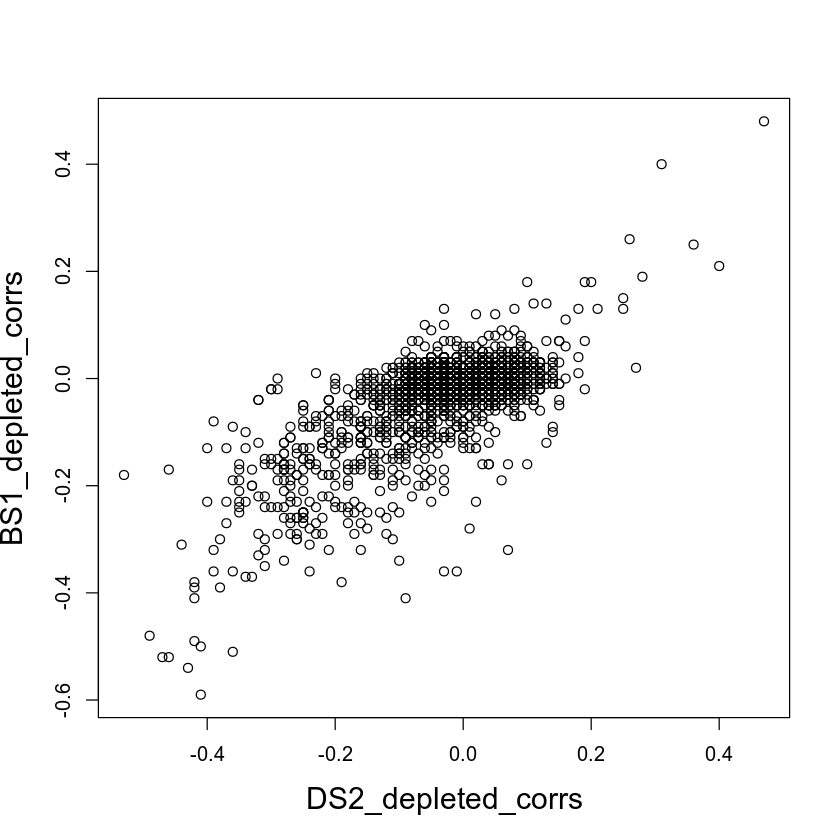

In [243]:
plot(DS2_depleted_corrs, BS1_depleted_corrs, cex.lab=1.5)

In [131]:
FGSEA_output = run_GSEA_byFile("canonical", MS4_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (68.47% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [132]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_ERBB1_DOWNSTREAM_PATHWAY,0.003952718,-0.8530215
PID_PDGFRB_PATHWAY,0.004449431,-0.8512016
PID_P53_DOWNSTREAM_PATHWAY,0.007999165,-0.8392485
PID_RAC1_PATHWAY,0.009424354,-0.8632763


In [244]:
TS1_depleted_corrs = pop_characteristic_genes("TS1", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
TS1_depleted_corrs[order(-TS1_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
TS1_depleted_corrs[order(TS1_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


TYROBP    AC090498.1        NBEAL1        S100A8         KLRB1 
         0.21          0.21          0.18          0.15          0.15 
       IGFBP7        FCER1G         CLIC3         SPON2           FTL 
         0.15          0.14          0.14          0.13          0.13 
        KLRF1       C1orf56      CDC42SE1        IFITM1          IL16 
         0.12          0.11          0.11          0.11          0.11 
         TLE1           TXK       ATP5EP2          GNLY        SH2D1B 
         0.11          0.11          0.10          0.09          0.09 
      HNRNPH1       LSINCT5         GPR85    AC009501.4         RAB24 
         0.08          0.08          0.08          0.08          0.08 
RP11-1000B6.3          LST1          GZMB         RPL17         GREM1 
         0.08          0.07          0.07          0.07          0.07

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MT-ND4  MT-ND3    RPL7  MT-CYB  MT-ND2  MT-CO3    IL32 MT-ATP6  MYL12A    CD3D 
  -0.40   -0.39   -0.39   -0.38   -0.37   -0.36   -0.35   -0.35   -0.35   -0.35 
   TPT1    TRAC    RPL9   UQCRB   RPS20    CCL5  MT-ND1    RPSA    BTF3    NPM1 
  -0.33   -0.32   -0.32   -0.31   -0.30   -0.27   -0.27   -0.26   -0.26   -0.26 
   RPS7   ACTG1   HLA-A   RPLP0    GZMH HNRNPA1   PTPRC  RPL10A     CD2    CD3G 
  -0.26   -0.24   -0.24   -0.24   -0.24   -0.24   -0.24   -0.24   -0.24   -0.24

In [133]:
FGSEA_output = run_GSEA_byFile("canonical", TS1_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (73.57% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [134]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
PID_CXCR4_PATHWAY,0.001386148,-0.8184828
PID_TCR_PATHWAY,0.003089896,-0.8629908
PID_PDGFRB_PATHWAY,0.003614776,-0.8302661
PID_CD8_TCR_PATHWAY,0.004523280,-0.8697437
PID_IL12_2PATHWAY,0.005591176,-0.8031797
PID_ERBB1_DOWNSTREAM_PATHWAY,0.015596869,-0.7875132
PID_IL12_STAT4_PATHWAY,0.025992934,-0.8142968
PID_CD8_TCR_DOWNSTREAM_PATHWAY,0.037620569,-0.7642333
PID_PI3KCI_PATHWAY,0.039371339,-0.8110898


In [248]:
TS2_depleted_corrs = pop_characteristic_genes("TS2", depleted=TRUE, res, var_gene_expr, var_genes)
print("Genes whose expression is most characteristic of the depleted population")
TS2_depleted_corrs[order(-TS2_depleted_corrs)][1:30]
print("Genes whose expression is most characteristic of the NON-depleted population")
TS2_depleted_corrs[order(TS2_depleted_corrs)][1:30]

Warning message in cor(t(as.matrix(var_gene_expr[, sel_cells])), in_pop * 1):
“the standard deviation is zero”


[1] "Genes whose expression is most characteristic of the depleted population"


AC090498.1       NBEAL1       S100A8      C1orf56     CDC42SE1          FTL 
        0.43         0.34         0.28         0.26         0.25         0.22 
       RPL17      HNRNPH1      ATP5EP2         NKG7         GNLY       TYROBP 
        0.21         0.20         0.16         0.15         0.14         0.14 
        CCL5        CRIP1         IL16        ZNF90        GPR85   AC009501.4 
        0.13         0.13         0.13         0.13         0.12         0.12 
      CTNNB1        GREM1         CCL4       SNHG25        TRA2A         GZMB 
        0.11         0.11         0.09         0.09         0.09         0.08 
        CST7 RP11-770J1.5        HLA-G       S100A9        KLRD1        PHKG1 
        0.08         0.08         0.08         0.07         0.07         0.07

[1] "Genes whose expression is most characteristic of the NON-depleted population"


MT-ND3  MT-ND2  MT-CYB  MT-CO3  MYL12A   UQCRB    NPM1  MT-ND4 MT-ATP6    LDHB 
  -0.50   -0.49   -0.48   -0.47   -0.46   -0.46   -0.46   -0.45   -0.44   -0.44 
   RPL7    TRAC    BTF3    TPT1   SARAF HNRNPA1   ITM2B     UBC   ANXA1 ARHGDIB 
  -0.43   -0.41   -0.40   -0.38   -0.38   -0.37   -0.37   -0.37   -0.37   -0.36 
   IL7R  MT-ND1   RPS20  GIMAP7     VIM   ACTG1  MYL12B  PABPC1   EIF3E   RPLP0 
  -0.36   -0.35   -0.35   -0.35   -0.34   -0.34   -0.34   -0.33   -0.33   -0.32

In [135]:
FGSEA_output = run_GSEA_byFile("canonical", TS2_depleted_corrs, filter_output=TRUE)

1234567891011121314151617181920212223242526272829303132333435363738394041424344454647484950515253545556575859606162636465666768697071727374757677787980818283848586878889909192939495969798991001011021031041051061071081091101111121131141151161171181191201211221231241251261271281291301311321331341351361371381391401411421431441451461471481491501511521531541551561571581591601611621631641651661671681691701711721731741751761771781791801811821831841851861871881891901911921931941951961971981992002012022032042052062072082092102112122132142152162172182192202212222232242252262272282292302312322332342352362372382392402412422432442452462472482492502512522532542552562572582592602612622632642652662672682692702712722732742752762772782792802812822832842852862872882892902912922932942952962972982993003013023033043053063073083093103113123133143153163173183193203213223233243253263273283293303313323333343353363373383393403413423433443453463473483493503513523533543553563573583593603613623633643653663673683693

Warning message in fgsea(input_genesets, rankList, nperm = 10000, minSize = 15, :
“There are ties in the preranked stats (68.67% of the list).
The order of those tied genes will be arbitrary, which may produce unexpected results.”


In [136]:
FGSEA_output = FGSEA_output[grep("PID", FGSEA_output$pathway),]
head(FGSEA_output, n=100)

pathway,padj,ES
<chr>,<dbl>,<dbl>
ENK_UV_RESPONSE_EPIDERMIS_DN,0.007611916,-0.7423739
PID_CXCR4_PATHWAY,0.011037970,-0.8297130
PID_CD8_TCR_PATHWAY,0.030030504,-0.8575049
PID_TCR_PATHWAY,0.049192064,-0.8291389


In [ ]:
library(ggplot2)
library(data.table)
library(reshape2)

In [260]:
df.x= data.frame(cbind(BS1_depleted_corrs, BS2_depleted_corrs, MS4_depleted_corrs, TS1_depleted_corrs,
                      TS2_depleted_corrs, DS1_depleted_corrs, DS2_depleted_corrs))
colnames(df.x) = c("BS1", "BS2", "MS4", "TS1", "TS2", "DS1", "DS2")
df.y = df.x
head(df.x)

,BS1,BS2,MS4,TS1,TS2,DS1,DS2
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LYZ,-0.12,-0.05,-0.30,-0.04,-0.08,-0.57,-0.04
S100A12,-0.05,-0.04,-0.29,-0.05,-0.05,-0.20,0.00
S100A8,0.25,0.10,-0.10,0.15,0.28,0.30,0.36
S100A9,0.07,0.01,-0.15,0.06,0.07,0.22,0.19
RP11-1143G9.4,0.02,-0.01,-0.07,-0.02,-0.02,-0.14,0.07
GNLY,-0.03,-0.02,0.04,0.09,0.14,0.11,0.00


Warning message:
“Removed 80096 rows containing missing values (geom_point).”


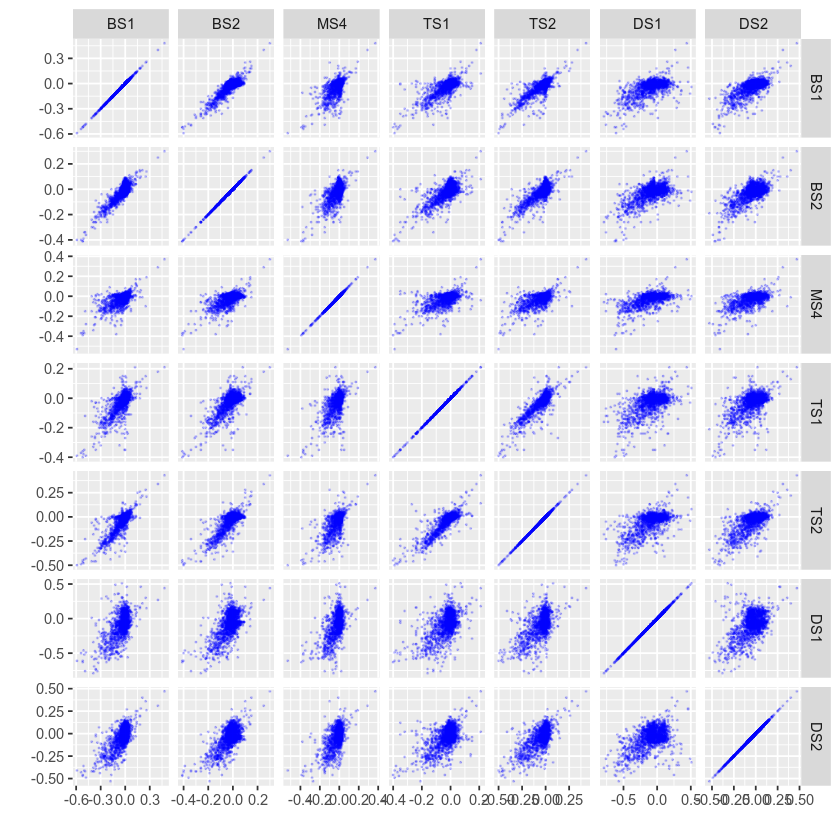

In [261]:
xDT <- data.table(melt(cbind(id=1:nrow(df.x),df.x),id="id",value.name="xval",variable.name="H"),key="id")
yDT <- data.table(melt(cbind(id=1:nrow(df.y),df.y),id="id",value.name="yval",variable.name="V"),key="id")
xy  <- xDT[yDT,allow.cartesian=T]

# simulates pairs() in base R
ggp = ggplot(xy,aes(x=xval,y=yval))
ggp = ggp + geom_point(colour = "blue", size = 0.2, alpha = 0.2)
ggp = ggp + facet_grid(V~H, scales="free")
ggp = ggp + labs(x="",y="")
print(ggp)